# Part 3: Neural Machine Translation (30 points)

## 1. Transformer Encoder (18 points)

In [32]:
import gc

gc.collect()

44

In [7]:
import sys
import os

PATH = "."
# part1 = "hw2-part1-bow_nli"
path_to_utils = 'pyfiles'

new_path_to_utils = os.path.join(PATH, path_to_utils)

sys.path.append(new_path_to_utils)

In [8]:
import global_variables
import nmt_dataset
import nnet_models_new

In [9]:
import torch

torch.manual_seed(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = os.path.join(PATH, 'data')

path_to_train_data = {'source': os.path.join(main_data_path, f"train.{source_name}"), 
                      'target': os.path.join(main_data_path, f"train.{target_name}")}
path_to_val_data = {'source': os.path.join(main_data_path, f"valid.{source_name}"), 
                      'target': os.path.join(main_data_path, f"valid.{target_name}")}

In [11]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [12]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 1024

In [13]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [14]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words
target_vocab = dataset_dict['train'].target_lang_obj.n_words
hidden_size = 512
enc_layers = 1
lr = 0.25
longest_label = 1
gradient_clip = 0.3
use_cuda = True

num_epochs = 20

### 1.1 Encoder

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
import math

#### Positional encoding

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(
            token_embedding + self.pos_embedding[: token_embedding.size(0), :]
        )

#### Token embedding

In [17]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    # [size of tokens, emb_dim] * float value
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

#### Transformer encoder

In [18]:
class EncoderTransformer(nn.Module):
    def __init__(
        self, emb_size: int, vocab_size: int, n_head: int, dropout: float = 0.1
    ):
        super(EncoderTransformer, self).__init__()

        self.embedding = TokenEmbedding(vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_head)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, input):
        embedded_tokens = self.embedding(input)
        positional_embedded_tokens = self.positional_encoding(embedded_tokens)
        outs = self.transformer(positional_embedded_tokens)
        hidden = outs.mean(dim=1).unsqueeze(dim=0)

        return outs, hidden


In [19]:
def get_encoder():
    n_head = 2
    src_emb_size = 512

    return EncoderTransformer(
        emb_size=src_emb_size,
        vocab_size=source_vocab,
        n_head=n_head
    ).to(device)

### Decoder (9 points)

In [20]:
rnn_layers = 1
hidden_size = 512
target_vocab_size = dataset_dict["train"].target_lang_obj.n_words
lr = 0.01
use_cuda = True
epochs = 20


In [21]:
# Basic RNN decoder (no attention)
dec_rnn = nnet_models_new.DecoderRNN(
    output_size=target_vocab_size,
    hidden_size=hidden_size,
    numlayers=rnn_layers
).to(device)

In [22]:
# RNN Decoder with Encoder attention
enc_attn_dec_rnn = nnet_models_new.Decoder_SelfAttn(
        output_size=target_vocab_size,
        hidden_size=hidden_size, 
        self_attention=False,
        encoder_attention=True,
    ).to(device)
 
# 
# target_lang=dataset_dict['train'].target_lang_obj,
# longest_label = longest_label,
# clip = gradient_clip

In [23]:
# RNN Decoder with Encoder & Self attention
enc_attn_dec_rnn_self_attn = nnet_models_new.Decoder_SelfAttn(
        output_size=target_vocab_size,
        hidden_size=hidden_size,
        self_attention=True,
        encoder_attention=True,
    ).to(device)

#### Seq2Seq Models

In [50]:
# Decoder RNN
model1 = nnet_models_new.seq2seq(
    encoder=get_encoder(),
    decoder=dec_rnn,
    target_lang=target_lang_obj,
    lr = lr,
    hiddensize = hidden_size,
    numlayers = hidden_size
)

In [51]:
# Encoder Attention - Decoder RNN
model2 = nnet_models_new.seq2seq(
    encoder=get_encoder(),
    decoder=enc_attn_dec_rnn,
    target_lang=target_lang_obj,
    lr = lr,
    hiddensize = hidden_size,
    numlayers = hidden_size
)

In [52]:
# Encoder Attention - Decoder RNN Self Attention
model3 = nnet_models_new.seq2seq(
    encoder=get_encoder(),
    decoder=enc_attn_dec_rnn_self_attn,
    target_lang=target_lang_obj,
    lr = lr,
    hiddensize = hidden_size,
    numlayers = hidden_size
)

### Training and evaluation

In [53]:
import time
from tqdm import tqdm

In [54]:
def save_models(nmt_model, enc_type):
    path = "./results/part3/models"
    if not os.path.exists(path):
        os.makedirs(path)
    filename = "nmt_enc_" + enc_type + "_dec_rnn.pth"
    torch.save(nmt_model, os.path.join(path, filename))

def train_model(
    dataloader, nmt, num_epochs=50, val_every=1, saved_model_path=".", enc_type="rnn"
):

    epoch_losses = list()
    bleu_scores = list()

    best_bleu = -1
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print("Epoch: [{}/{}]".format(epoch, num_epochs))

        for i, data in tqdm(
            enumerate(dataloader["train"]), total=len(dataloader["train"])
        ):
            _, curr_loss = nmt.train_step(data)
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader["train"])
        epoch_losses.append(epoch_loss)

        print(
            "epoch {} loss = {}, time = {}".format(
                epoch, epoch_loss, time.time() - start
            )
        )

        val_bleu_score = nmt.get_bleu_score(dataloader["val"])
        bleu_scores.append(val_bleu_score)

        sys.stdout.flush()
        
        if epoch % val_every == 0:
            print("validation bleu: ", val_bleu_score)
            sys.stdout.flush()

            nmt.scheduler_step(val_bleu_score)

            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, enc_type)

        print("=" * 50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    return epoch_losses, bleu_scores


In [55]:
epoch_losses1, bleu_scores1 = train_model(dataloader=dataloader_dict, nmt=model1, num_epochs=20, enc_type="rnn")

Epoch: [0/20]


100%|██████████| 903/903 [03:04<00:00,  4.88it/s]


epoch 0 loss = 2.4788487558217014, time = 184.88498973846436
validation bleu:  0.8414027382744814
Epoch: [1/20]


100%|██████████| 903/903 [03:00<00:00,  5.02it/s]


epoch 1 loss = 1.7193148736805879, time = 180.05086541175842
validation bleu:  2.521539817410693
Epoch: [2/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 2 loss = 1.5471271377465257, time = 180.1468551158905
validation bleu:  3.9005288918477232
Epoch: [3/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 3 loss = 1.4297666751665135, time = 180.20556926727295
validation bleu:  5.588337306799697
Epoch: [4/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 4 loss = 1.3401766958030752, time = 180.17118644714355
validation bleu:  6.818778500501381
Epoch: [5/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 5 loss = 1.2656132285117048, time = 180.3040041923523
validation bleu:  7.955441757417658
Epoch: [6/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 6 loss = 1.2107043975215417, time = 180.16247510910034
validation bleu:  9.444447386177043
Epoch: [7/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 7 loss = 1.1542114064278926, time = 180.19342613220215
validation bleu:  10.49315051518233
Epoch: [8/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 8 loss = 1.09909272636158, time = 180.32004165649414
validation bleu:  11.141124099904365
Epoch: [9/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 9 loss = 1.0560478269723828, time = 180.29728960990906
validation bleu:  12.4719469203077
Epoch: [10/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 10 loss = 1.0190593216110306, time = 180.29223370552063
validation bleu:  12.772753270624598
Epoch: [11/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 11 loss = 0.9802152711159631, time = 180.22376441955566
validation bleu:  13.936820647538662
Epoch: [12/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 12 loss = 0.9449367997786268, time = 180.36418104171753
validation bleu:  14.829258261139996
Epoch: [13/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 13 loss = 0.9136295486262206, time = 180.30983304977417
validation bleu:  15.917296692428593
Epoch: [14/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 14 loss = 0.8832030416459076, time = 180.30967473983765
validation bleu:  16.333823174329307
Epoch: [15/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 15 loss = 0.8569675392882768, time = 180.32672119140625
validation bleu:  16.997930271587148
Epoch: [16/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 16 loss = 0.8330782475661598, time = 180.3126015663147
validation bleu:  17.392405795853747
Epoch: [17/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 17 loss = 0.8101294263784804, time = 180.23449325561523
validation bleu:  18.352793461005458
Epoch: [18/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 18 loss = 0.7856334660734449, time = 180.3032932281494
validation bleu:  18.38130217766168
Epoch: [19/20]


100%|██████████| 903/903 [03:00<00:00,  5.01it/s]


epoch 19 loss = 0.7634698930108798, time = 180.34588313102722
validation bleu:  19.30860443739976
Training completed. Best BLEU is 19.30860443739976


In [56]:
epoch_losses2, bleu_scores2 = train_model(dataloader=dataloader_dict, nmt=model2, num_epochs=20, enc_type="rnn_attn")

Epoch: [0/20]


100%|██████████| 903/903 [05:23<00:00,  2.79it/s]


epoch 0 loss = 2.5184361402642557, time = 323.8425087928772
validation bleu:  1.0095983078795603
Epoch: [1/20]


100%|██████████| 903/903 [05:18<00:00,  2.83it/s]


epoch 1 loss = 1.8211936326253981, time = 318.98900032043457
validation bleu:  1.6631927368123043
Epoch: [2/20]


100%|██████████| 903/903 [05:19<00:00,  2.82it/s]


epoch 2 loss = 1.6580705747651896, time = 319.69283080101013
validation bleu:  2.6185809647818945
Epoch: [3/20]


100%|██████████| 903/903 [05:19<00:00,  2.82it/s]


epoch 3 loss = 1.5416196473809176, time = 319.7763707637787
validation bleu:  3.6022554164575906
Epoch: [4/20]


100%|██████████| 903/903 [05:18<00:00,  2.83it/s]


epoch 4 loss = 1.4581098131431165, time = 318.9794850349426
validation bleu:  5.116509554717155
Epoch: [5/20]


100%|██████████| 903/903 [05:19<00:00,  2.82it/s]


epoch 5 loss = 1.3867611140507796, time = 319.856835603714
validation bleu:  6.224091998926953
Epoch: [6/20]


100%|██████████| 903/903 [05:18<00:00,  2.83it/s]


epoch 6 loss = 1.3292331779385986, time = 318.7007520198822
validation bleu:  6.644395662433681
Epoch: [7/20]


100%|██████████| 903/903 [05:20<00:00,  2.82it/s]


epoch 7 loss = 1.2720555403699907, time = 320.0831968784332
validation bleu:  7.879066564891741
Epoch: [8/20]


100%|██████████| 903/903 [05:20<00:00,  2.82it/s]


epoch 8 loss = 1.2260481688799387, time = 320.120689868927
validation bleu:  8.408815957018751
Epoch: [9/20]


100%|██████████| 903/903 [05:19<00:00,  2.82it/s]


epoch 9 loss = 1.1862781961362887, time = 319.9045617580414
validation bleu:  8.519186904894163
Epoch: [10/20]


100%|██████████| 903/903 [05:01<00:00,  2.99it/s]


epoch 10 loss = 1.1449026792812453, time = 301.99937558174133
validation bleu:  9.657992910028039
Epoch: [11/20]


100%|██████████| 903/903 [05:19<00:00,  2.82it/s]


epoch 11 loss = 1.1103190309713582, time = 319.7403781414032
validation bleu:  10.60488922049351
Epoch: [12/20]


100%|██████████| 903/903 [05:19<00:00,  2.83it/s]


epoch 12 loss = 1.0818409655049261, time = 319.0589921474457
validation bleu:  10.966371141801394
Epoch: [13/20]


100%|██████████| 903/903 [04:55<00:00,  3.05it/s]


epoch 13 loss = 1.04531364405274, time = 295.97315740585327
validation bleu:  12.036744386238905
Epoch: [14/20]


100%|██████████| 903/903 [05:19<00:00,  2.82it/s]


epoch 14 loss = 1.0161586092952082, time = 319.8248596191406
validation bleu:  12.576998841093056
Epoch: [15/20]


100%|██████████| 903/903 [05:21<00:00,  2.81it/s]


epoch 15 loss = 0.9855668515065976, time = 321.7123749256134
validation bleu:  13.196817788884905
Epoch: [16/20]


100%|██████████| 903/903 [05:22<00:00,  2.80it/s]


epoch 16 loss = 0.9576858616746541, time = 322.38038182258606
validation bleu:  13.885326908039733
Epoch: [17/20]


100%|██████████| 903/903 [05:21<00:00,  2.81it/s]


epoch 17 loss = 0.9324022659563675, time = 321.8498923778534
validation bleu:  14.497915546775292
Epoch: [18/20]


100%|██████████| 903/903 [05:20<00:00,  2.81it/s]


epoch 18 loss = 0.9128769559585639, time = 320.8040494918823
validation bleu:  15.354768903970488
Epoch: [19/20]


100%|██████████| 903/903 [05:20<00:00,  2.82it/s]


epoch 19 loss = 0.8914321307856116, time = 320.6550061702728
validation bleu:  15.809384792149263
Training completed. Best BLEU is 15.809384792149263


In [ ]:
epoch_losses3, bleu_scores3 = train_model(dataloader=dataloader_dict, nmt=model3, num_epochs=20, enc_type="rnn_self_attn")

Epoch: [0/20]


100%|██████████| 903/903 [05:27<00:00,  2.75it/s]


epoch 0 loss = 1.613760178799381, time = 327.92184495925903
validation bleu:  3.940948333081859
Epoch: [1/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 1 loss = 1.5032738663693468, time = 328.09890937805176
validation bleu:  4.689908579787515
Epoch: [2/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 2 loss = 1.4242889830308367, time = 328.77898716926575
validation bleu:  5.870511003989808
Epoch: [3/20]


100%|██████████| 903/903 [05:27<00:00,  2.75it/s]


epoch 3 loss = 1.364083934859976, time = 327.7711937427521
validation bleu:  6.860385371220207
Epoch: [4/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 4 loss = 1.3011667763407972, time = 328.3767249584198
validation bleu:  7.892829074325486
Epoch: [5/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 5 loss = 1.2461982134436715, time = 328.83016538619995
validation bleu:  9.121874079664051
Epoch: [6/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 6 loss = 1.1980890682501386, time = 328.7175874710083
validation bleu:  9.858055611395933
Epoch: [7/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 7 loss = 1.152898799211348, time = 328.7536709308624
validation bleu:  10.9373048846712
Epoch: [8/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 8 loss = 1.1143060527238602, time = 328.6188426017761
validation bleu:  11.891298271664716
Epoch: [9/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 9 loss = 1.0797682112105529, time = 328.12601685523987
validation bleu:  12.839933808318905
Epoch: [10/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 10 loss = 1.0401352778621686, time = 328.45200514793396
validation bleu:  13.726489303953686
Epoch: [11/20]


100%|██████████| 903/903 [05:26<00:00,  2.76it/s]


epoch 11 loss = 1.0135531291481137, time = 326.98794651031494
validation bleu:  14.07511242390332
Epoch: [12/20]


100%|██████████| 903/903 [05:28<00:00,  2.75it/s]


epoch 12 loss = 0.9812172471750878, time = 328.2261006832123
validation bleu:  15.129475889546327
Epoch: [13/20]


100%|██████████| 903/903 [05:30<00:00,  2.74it/s]


epoch 13 loss = 0.9476276164831117, time = 330.1407904624939
validation bleu:  15.586564047479442
Epoch: [14/20]


 70%|██████▉   | 628/903 [03:49<01:52,  2.44it/s]

In [4]:
import matplotlib.pyplot as plt
import os

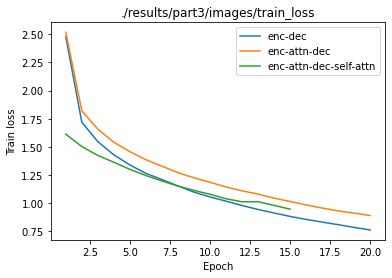

In [5]:
x = range(1, len(epoch_losses1)+1)
plt.plot(x, epoch_losses1, label="enc-dec")
plt.plot(x, epoch_losses2, label="enc-attn-dec")
plt.plot(x, epoch_losses3 + [None] * (len(epoch_losses2) - len(epoch_losses3)), label="enc-attn-dec-self-attn")
plt.xlabel("Epoch")
plt.ylabel("Train loss")
path = os.path.join(".", "results", "part3", "images", "train_loss")
plt.title(path)
plt.legend(loc="upper right")
plt.show()

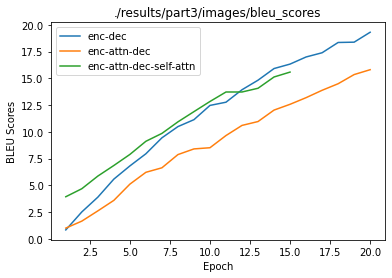

In [6]:
x = range(1, len(bleu_scores1)+1)
plt.plot(x, bleu_scores1, label="enc-dec")
plt.plot(x, bleu_scores2, label="enc-attn-dec")
plt.plot(x, bleu_scores3 + [None] * (len(bleu_scores2) - len(bleu_scores3)), label="enc-attn-dec-self-attn")
plt.xlabel("Epoch")
plt.ylabel("BLEU Scores")
path = os.path.join(".", "results", "part3", "images", "bleu_scores")
plt.title(path)
plt.legend(loc="upper left")
plt.show()

## 2. Attention Visualization

In [ ]:
# !pip install googletrans==4.0.0-rc1

In [25]:
import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [26]:
def get_encoded_batch(sentence, lang_obj, use_cuda):
    """accepts only bsz = 1.
    input: one sentence as a string
    output: named tuple with vector and length"""

    sentence = sentence + " " + global_variables.EOS_TOKEN
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)

    device = (
        torch.device("cuda")
        if use_cuda and torch.cuda.is_available()
        else torch.device("cpu")
    )

    named_returntuple = namedtuple(
        "namedtuple",
        ["text_vecs", "text_lens", "label_vecs", "label_lens", "use_packed"],
    )
    return_tuple = named_returntuple(
        tensor.to(device),
        torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
        None,
        None,
        False,
    )
    return return_tuple


def get_translation(nmt_model, sentence, lang_obj, use_cuda, title):
    print("source: ", sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda)
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn=True)
    prediction = prediction[0]
    print("prediction: ", prediction)
    # print(
    #     "GT on sentence (src->tgt): ",
    #     translator.translate(sentence, src=source_name, dest=target_name).text,
    # )
    # print(
    #     "GT on prediction (tgt->src): ",
    #     translator.translate(prediction, src=target_name, dest=source_name).text,
    # )

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list]
            attn_matrix = np.stack(attn_matrix)[:, :, 0]
            showAttention(sentence, prediction, attn_matrix, title)


def showAttention(input_sentence, output_words, attentions, title):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap="bone", aspect="auto")
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(
        [""] + input_sentence.split(" ") + [global_variables.EOS_TOKEN], rotation=90
    )
    ax.set_yticklabels([""] + output_words.split(" ") + [global_variables.EOS_TOKEN])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    path = os.path.join(".", "results", "part3", "images", title)
    plt.savefig(path)
    plt.show()



a good theory is <unk> by the fact that it makes a number of <unk> that could in principle be <unk> or <unk> by observation .
une bonne theorie se <unk> par le fait de faire une serie de predictions qui en principe pourraient etre <unk> ou mises en defaut par l observation .
source:  a good theory is <unk> by the fact that it makes a number of <unk> that could in principle be <unk> or <unk> by observation .
prediction:  tout le monde est que ce soit un peu de gens qui ne mange que de l endroit ou un locuteur natif .
source:  a good theory is <unk> by the fact that it makes a number of <unk> that could in principle be <unk> or <unk> by observation .
prediction:  cela fait un bon moment que les gens se sont bien sur qu il soit en train de faire un peu de son travail .


<ipython-input-26-06834a10b52e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
<ipython-input-26-06834a10b52e>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words.split(" ") + [global_variables.EOS_TOKEN])


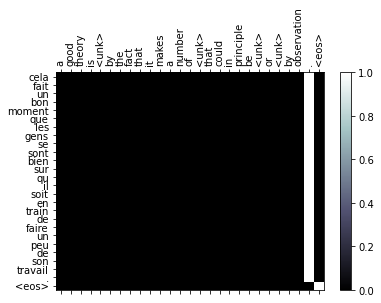

source:  a good theory is <unk> by the fact that it makes a number of <unk> that could in principle be <unk> or <unk> by observation .
prediction:  ce qui pourrait etre un grand probleme est que l on pouvait etre en train d etre un des pays qui pouvait etre en train de se passer les autres .


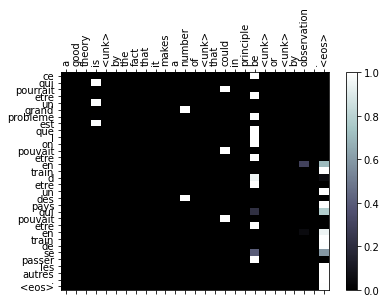





these three hours of driving have worn me out . let s stop at the first rest area we see .
ces trois heures au volant m ont <unk> . arretons nous a la premiere <unk> de repos que nous verrons .
source:  these three hours of driving have worn me out . let s stop at the first rest area we see .
prediction:  au moins de trois heures je dois partir .
source:  these three hours of driving have worn me out . let s stop at the first rest area we see .
prediction:  allons nous faire la meme chose que le reste de la maison s est arrete .


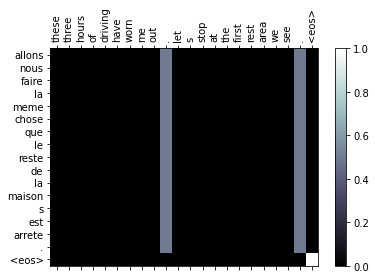

source:  these three hours of driving have worn me out . let s stop at the first rest area we see .
prediction:  apres que nous nous sommes a la gare des deux fois plus de mes amis .


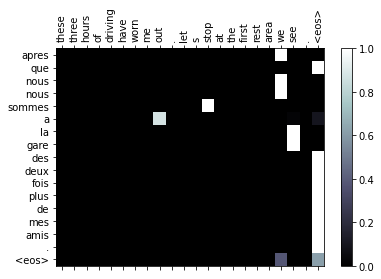





i m sorry that i haven t been able to be here for you like i should have been .
je suis desolee d avoir ete dans l incapacite d etre la pour toi comme j aurais du l etre .
source:  i m sorry that i haven t been able to be here for you like i should have been .
prediction:  je suis desole de ne pas avoir ete a l instant .
source:  i m sorry that i haven t been able to be here for you like i should have been .
prediction:  je n ai pas a croire que vous etiez en retard .


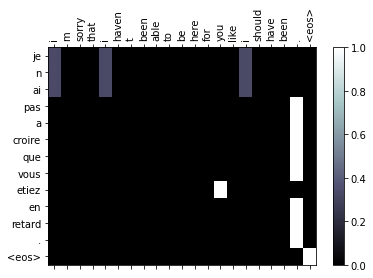

source:  i m sorry that i haven t been able to be here for you like i should have been .
prediction:  je suis desole d avoir ete a l instant que je devrais etre a toi .


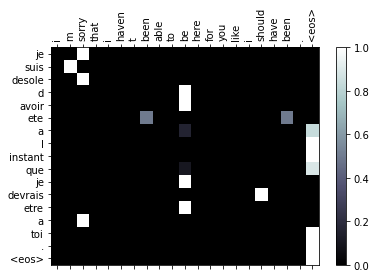

In [66]:
def pick_val_examples():
    batch = next(iter(dataloader_dict['val']))
    t1 = batch[0][:3]
    t2 = batch[1][:3]
    t3 = batch[2][:3]
    t4 = batch[3][:3]
    return t1, t2, t3, t4

def print_input_sequence(input):
    print(source_lang_obj.vec2txt(input.tolist()))

def print_output_sequence(output):
    print(target_lang_obj.vec2txt(output.tolist()))

def print_plot(input):
    models = [model1, model2, model3]
    titles = ["encoder_decoder", "encoder_attentn", "encoder_attentn_decoder_self_attentn"]
    
    for i, model in enumerate(models):
        get_translation(model, source_lang_obj.vec2txt(input.tolist()), source_lang_obj, use_cuda, titles[i])

t1, t2, t3, t4 = pick_val_examples()
for i in range(3):
    print("\n")
    print_input_sequence(t1[i][:t2[i].item()])
    print_output_sequence(t3[i][:t4[i].item()])
    print_plot(t1[i][:t2[i].item()])
    print("\n")